In [1]:
import pandas as pd
import numpy as np
from scipy.stats import truncnorm
import re
import random
import geopandas as gpd
from numba import jit, njit
from shapely import MultiPoint, Point
from shapely.ops import nearest_points
import matplotlib.pyplot as plt

In [2]:
streetNetwork_nodes = gpd.read_file('./Data/streetnetwork_nodes.gpkg')
roadPoints = streetNetwork_nodes['geometry']
roadNodes = MultiPoint(roadPoints)

<h1>CREATE DWELLINGS</h1>

In [3]:
zoneShape = gpd.read_file('Data/TorontoZoneShape/TorontoZones_26917.shp')

In [4]:
zoneData = pd.read_csv('./Data/combinedZoneData.csv')

In [ ]:
zoneData.dtypes

In [5]:
dwelling_counts = pd.read_csv('./Data/DwellingTypesByZone2006.csv')

In [ ]:
dwellings = pd.DataFrame(columns=['id', 'zone', 'type', 'hhId', 'bedrooms', 'quality', 'monthlyCost', 'restriction', 'yearBuilt', 'floor', 'building', 'usage', 'coordX', 'coordY'])

In [6]:
dwelling_counts = dwelling_counts[dwelling_counts['Geography'].astype(str).isin(zoneData['DAUID'].astype(str))]
dwelling_counts = dwelling_counts.reset_index(drop=True)

zoneShape = zoneShape[zoneShape['DAUID'].isin(zoneData['DAUID'].astype(str))]
zoneShape = zoneShape.reset_index(drop=True)

<Axes: >

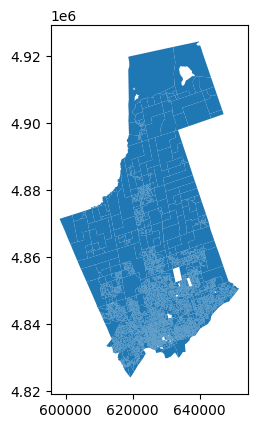

In [7]:
zoneShape.plot()

In [8]:
for i, row in zoneData[~zoneData['DAUID'].astype(str).isin(dwelling_counts['Geography'].astype(str))].iterrows():
    print(row['DAUID'])
    index = len(dwelling_counts)
    dwelling_counts.loc[index, "Geography"] = row['DAUID']
    dwelling_counts.loc[index, "Total - Structural type of dwelling"] = 200

35200545.0
35202819.0
35202840.0
35203156.0
35204130.0


In [9]:
polygons = []
for i in range(zoneShape.shape[0]):
    polygons.append(zoneShape.iloc[i]['geometry'])
    
geoseries = gpd.GeoSeries(polygons, dwelling_counts['Geography'])
dwelling_coords = geoseries.sample_points(size=dwelling_counts['Total - Structural type of dwelling'].astype(float).astype(int))
dwelling_coords = dwelling_coords.explode(index_parts=True)

In [ ]:
total_dwelling_count_GTA = float(dwelling_counts['Total - Structural type of dwelling'].astype(float).sum())
print(total_dwelling_count_GTA)

In [ ]:
dwelling_counts.shape[0]

In [10]:
def snapPosition(args:"tuple[int, pd.DataFrame]"):
    num = args[0]
    dwellings_sample = args[1]
    dwellingCount = 0
    for i, dwelling in dwellings_sample.iterrows():
        point = Point(float(random.choice(dwelling_coords[str(dwelling['zone'])]).x), float(random.choice(dwelling_coords[str(dwelling['zone'])]).y))
        p1, p2 = nearest_points(point, roadNodes)
        dwellings.loc[i, 'coordX'] = p2.x
        dwellings.loc[i, 'coordY'] = p2.y
        if dwellingCount%10000==0:
            print(num, ':', dwellingCount)
        dwellingCount+=1

In [ ]:
def createDwellings(args:"tuple[int, pd.DataFrame]"):
    num = args[0]
    counts = args[1]
    numRows = 0
    dwellings = pd.DataFrame(columns=['id', 'zone', 'type', 'hhId', 'bedrooms', 'quality', 'monthlyCost', 'restriction', 'yearBuilt', 'floor', 'building', 'usage', 'coordX', 'coordY'])
    dwelling_number = 0
    for i,dwelling in counts.iterrows():
        numDwellings = int(float(dwelling['Total - Structural type of dwelling']))
        for j in range(numDwellings):
            point = Point(float(dwelling_coords[dwelling['Geography']][j].x), float(dwelling_coords[dwelling['Geography']][j].y))
            p1, p2 = nearest_points(point, roadNodes)

            dwellings.loc[len(dwellings)] = [dwelling_number, int(dwelling['Geography']), ['SFD', 'SFA', 'MF234', 'MF5plus', 'MH'][random.randint(0,4)], -1, random.randint(1,4), random.randint(1,4), random.randint(1500,3500), 0, 2006, 1500, 2, -1, p2.x, p2.y]
            dwelling_number+=1
        numRows += 1
        print(numRows,'/1000', dwelling['Geography'])
    
    return dwellings


In [11]:
import threading
class ReturnableThread(threading.Thread):
    # This class is a subclass of Thread that allows the thread to return a value.
    def __init__(self, group=None, target=None, name=None,
                 args=(), kwargs={}, Verbose=None):
        self.args = args
        threading.Thread.__init__(self, group, target, name, args, kwargs)

        self.target = target
        self.result = None
    
    def run(self) -> None:
        self.result = self.target(self.args)


Create threads to make dwellings

In [ ]:
thread1 = ReturnableThread(target=createDwellings, args=(1, dwelling_counts[:1000]))
thread2 = ReturnableThread(target=createDwellings, args=(2, dwelling_counts[1000:2000]))
thread3 = ReturnableThread(target=createDwellings, args=(3, dwelling_counts[2000:3000]))
thread4 = ReturnableThread(target=createDwellings, args=(4, dwelling_counts[3000:4000]))
thread5 = ReturnableThread(target=createDwellings, args=(5, dwelling_counts[4000:5000]))

thread1.start()
thread2.start()
thread3.start()
thread4.start()
thread5.start()

thread1.join()
thread2.join()
thread3.join()
thread4.join()
thread5.join()

allDwellings = pd.concat([thread1.result, thread2.result, thread3.result, thread4.result, thread5.result])

Create threads to snap dwelling positions

In [14]:
dwellings = pd.read_csv('./Output/dd_2006_linked.csv')

In [15]:
thread1 = ReturnableThread(target=snapPosition, args=(1, dwellings[:250000]))
thread2 = ReturnableThread(target=snapPosition, args=(2, dwellings[250000:500000]))
thread3 = ReturnableThread(target=snapPosition, args=(3, dwellings[500000:750000]))
thread4 = ReturnableThread(target=snapPosition, args=(4, dwellings[750000:1000000]))
thread5 = ReturnableThread(target=snapPosition, args=(5, dwellings[1000000:1252370]))

thread1.start()
thread2.start()
thread3.start()
thread4.start()
thread5.start()

thread1.join()
thread2.join()
thread3.join()
thread4.join()
thread5.join()

3 : 0
1 : 0
4 : 0
2 : 0
5 : 0
3 : 10000
2 : 10000
4 : 10000
5 : 10000
1 : 10000
3 : 20000
2 : 20000
4 : 20000
5 : 20000
1 : 20000
3 : 30000
2 : 30000
4 : 30000
5 : 30000
1 : 30000
2 : 40000
3 : 40000
4 : 40000
5 : 40000
1 : 40000
2 : 50000
3 : 50000
4 : 50000
5 : 50000
1 : 50000
2 : 60000
3 : 60000
4 : 60000
5 : 60000
1 : 60000
2 : 70000
3 : 70000
4 : 70000
5 : 70000
1 : 70000
2 : 80000
3 : 80000
4 : 80000
5 : 80000
1 : 80000
2 : 90000
3 : 90000
4 : 90000
5 : 90000
1 : 90000
2 : 100000
3 : 100000
4 : 100000
5 : 100000
1 : 100000
2 : 110000
3 : 110000
4 : 110000
5 : 110000
1 : 110000
2 : 120000
3 : 120000
4 : 120000
5 : 120000
1 : 120000
2 : 130000
4 : 130000
3 : 130000
5 : 130000
1 : 130000
2 : 140000
4 : 140000
3 : 140000
5 : 140000
1 : 140000
2 : 150000
4 : 150000
3 : 150000
5 : 150000
1 : 150000
2 : 160000
4 : 160000
3 : 160000
5 : 160000
1 : 160000
2 : 170000
3 : 170000
4 : 170000
5 : 170000
1 : 170000
2 : 180000
3 : 180000
4 : 180000
5 : 180000
1 : 180000
2 : 190000
3 : 190000
4 :

Exception in thread Thread-10 (snapPosition):
Traceback (most recent call last):
  File "c:\Users\lukeg\Documents\SILO_GTA\.venv\Lib\site-packages\pandas\core\indexes\base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\\_libs\\hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\\_libs\\hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: '35200545'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\lukeg\AppData\Local\Programs\Python\Python312\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\lukeg\AppData\Local\Temp\ipykernel_16160\2957097841.py", line 13,

In [ ]:
dwellings.to_csv('./Output/dd_2006_linked_snapped.csv', index=False)

In [ ]:
allDwellings.to_csv('./Output/dd_2006.csv', index=False)